In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import pandas as pd
import pathlib
from keras_tuner.tuners import RandomSearch


base_dir = '/content/Dataset 2'

In [1]:
!pip install keras-tuner

In [3]:
!pip install unrar
!unrar x /content/Dataset2.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset2.rar

Creating    Dataset 2                                                 OK
Creating    Dataset 2/faringitis                                      OK
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.5818f7fd9c45883c801d938b09b29755.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.a04e34f6d58fe952bc090614f030910c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.b120ee8edff9c00d1f305d865b733a42.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.6bd81eac38835aee94df9c1e5079d67c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.873f55c8af860852930aef580ce9463d.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.c1c8132c26736bc54117fbc7d64a2714.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1583073772026_jpeg.rf.61c

In [ ]:
import os
import shutil
import random


base_dir = 'dataset'


classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]


splits = ['train', 'val', 'test']
split_ratios = [0.7, 0.2, 0.1]  


for split in splits:
    for cls in classes:
        split_folder = os.path.join(base_dir + f'_{split}', cls)
        os.makedirs(split_folder, exist_ok=True)


for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_cutoff = int(split_ratios[0] * total)
    val_cutoff = train_cutoff + int(split_ratios[1] * total)

    split_data = {
        'train': images[:train_cutoff],
        'val': images[train_cutoff:val_cutoff],
        'test': images[val_cutoff:]
    }

    for split in splits:
        for img in split_data[split]:
            src = os.path.join(base_dir, cls, img)
            dst = os.path.join(base_dir + f'_{split}', cls, img)
            shutil.copy2(src, dst)

print("✅ Pemisahan dataset selesai!")


✅ Pemisahan dataset selesai!


In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset 2_train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset 2_val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Dataset 2_test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False
)


Found 1721 files belonging to 2 classes.
Found 491 files belonging to 2 classes.
Found 248 files belonging to 2 classes.


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50

def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hp.Int('units1', min_value=64, max_value=512, step=64), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units3', min_value=16, max_value=128, step=16), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.1))(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='pharyngitis_resnet50'
)


Reloading Tuner from kt_dir/pharyngitis_resnet50/tuner0.json


In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[stop_early]
)


Trial 10 Complete [00h 03m 10s]
val_accuracy: 0.8818737268447876

Best val_accuracy So Far: 0.9083502888679504
Total elapsed time: 00h 45m 40s


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,186,305 (92.26 MB)

 Trainable params: 598,593 (2.28 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
test_loss, test_acc = best_model.evaluate(test_ds)
print(f'Test Accuracy: {test_acc:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 680ms/step - accuracy: 0.9142 - loss: 0.2147
Test Accuracy: 0.92


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters:")
print(f" - units1: {best_hps.get('units1')}")
print(f" - units2: {best_hps.get('units2')}")
print(f" - units3: {best_hps.get('units3')}")
print(f" - dropout1: {best_hps.get('dropout1')}")
print(f" - dropout2: {best_hps.get('dropout2')}")
print(f" - dropout3: {best_hps.get('dropout3')}")
print(f" - Learning Rate: {best_hps.get('lr')}")

Best hyperparameters:
 - units1: 256
 - units2: 256
 - units3: 32
 - dropout1: 0.2
 - dropout2: 0.2
 - dropout3: 0.30000000000000004
 - Learning Rate: 0.0001


In [34]:

best_model = tuner.hypermodel.build(best_hps)

for layer in best_model.layers[:10]:
    layer.trainable = True
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=32,
    verbose=1,
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 414ms/step - accuracy: 0.5668 - loss: 0.7228 - val_accuracy: 0.7271 - val_loss: 0.5864
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - accuracy: 0.6901 - loss: 0.5803 - val_accuracy: 0.7169 - val_loss: 0.5523
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.7622 - loss: 0.5002 - val_accuracy: 0.7637 - val_loss: 0.4852
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.7866 - loss: 0.4527 - val_accuracy: 0.8208 - val_loss: 0.3932
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.8065 - loss: 0.4006 - val_accuracy: 0.8147 - val_loss: 0.3965
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.8400 - loss: 0.3486 - val_accuracy: 0.8432 - val_loss: 0.3599
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8621 - loss: 0.3235 - val_accuracy: 0.8371 - val_loss: 0.3879
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.8811 - loss: 0.2649 - 

In [53]:
best_model.save('ResNet50_dataset_updatedv2_noaug.keras')

In [35]:
best_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,411,269 (96.94 MB)

 Trainable params: 612,481 (2.34 MB)

 Non-trainable params: 23,573,824 (89.93 MB)

 Optimizer params: 1,224,964 (4.67 MB)

In [36]:
test_loss, test_acc = best_model.evaluate(test_ds)
print(f'Test Accuracy: {test_acc:.2f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.9583 - loss: 0.1333
Test Accuracy: 0.94


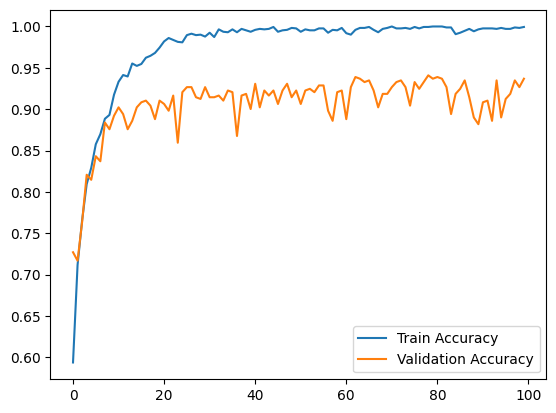

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


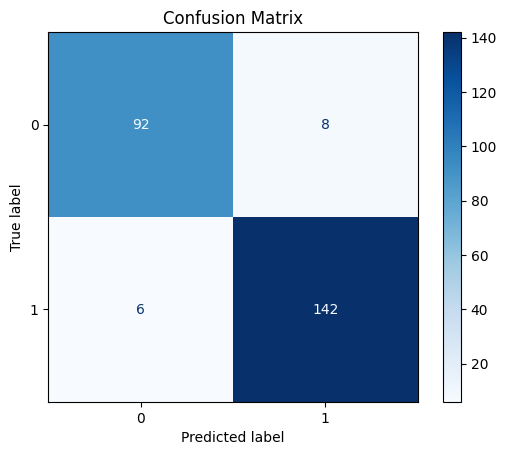

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       100
           1       0.95      0.96      0.95       148

    accuracy                           0.94       248
   macro avg       0.94      0.94      0.94       248
weighted avg       0.94      0.94      0.94       248



In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

true_labels = []
predictions = []

for images, labels in test_ds:  # ← PASTIKAN test_ds bukan di-shuffle
    true_labels.extend(labels.numpy())
    preds = best_model.predict(images)

    if preds.shape[1] == 1:
        preds = np.round(preds).astype(int).flatten()
    else:
        preds = np.argmax(preds, axis=1)

    predictions.extend(preds)

# Buat confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions))


In [57]:
!rar a "/content/kt_dir" "/content/kt_dir"


RAR 6.23   Copyright (c) 1993-2023 Alexander Roshal   1 Aug 2023
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Creating archive /content/kt_dir.rar

Adding    /content/kt_dir/pharyngitis_resnet50/trial_00/checkpoint.weights.h5       0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10%  OK 
Adding    /content/kt_dir/pharyngitis_resnet50/trial_00/trial.json        10%  OK 
Adding    /content/kt_dir/pharyngitis_resnet50/trial_00/build_config.json      10%  OK 
Adding    /content/kt_dir/pharyngitis_resnet50/trial_05/checkpoint.weights.h5      10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20%  OK 
Adding    /content/kt_dir/pharyngitis_resnet50/trial_05/trial.json        20%  OK 
Adding    /content/kt_dir/pharyngitis_resnet50/trial_05/build_config.json      20%  OK 
Adding    /content/kt_dir/pharyngitis_resnet50/trial_02/checkpoint.weig

In [56]:
!apt-get update
!apt-get install -y rar

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,798 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,532 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://ppa.launchp